In [ ]:
import tensorflow as tf
import keras
import sys
from matplotlib import pyplot
from keras.models import Sequential, load_model, Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.layers import Dense, Input, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Add, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.activations import relu, softmax
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras import backend as K
from sklearn.metrics import confusion_matrix
from matplotlib import animation, rc
import matplotlib.patches as mpatches
from IPython.display import HTML, display, clear_output, SVG
from tensorflow.keras.optimizers import Adadelta
import ipywidgets as widgets
from tensorflow.keras.applications.resnet50 import ResNet50
import random

In [ ]:
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

In [ ]:
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model


In [ ]:
def model():
	base_model = ResNet50(include_top=False, input_shape=(128, 128, 3), pooling='max')
	
	for layer in base_model.layers:
		layer.trainable = False
	model = Sequential()
	model.add(Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='relu', input_shape=(32,32,3)))
	model.add(BatchNormalization())
	model.add(Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='relu'))
	model.add(BatchNormalization())
	model.add(base_model)
	model.add(Flatten())
	model.add(Dense(1024, activation='relu'))
	model.add(Dense(512, activation='relu'))
	model.add(Dense(10, activation='softmax'))
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	
	return model

94781440/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


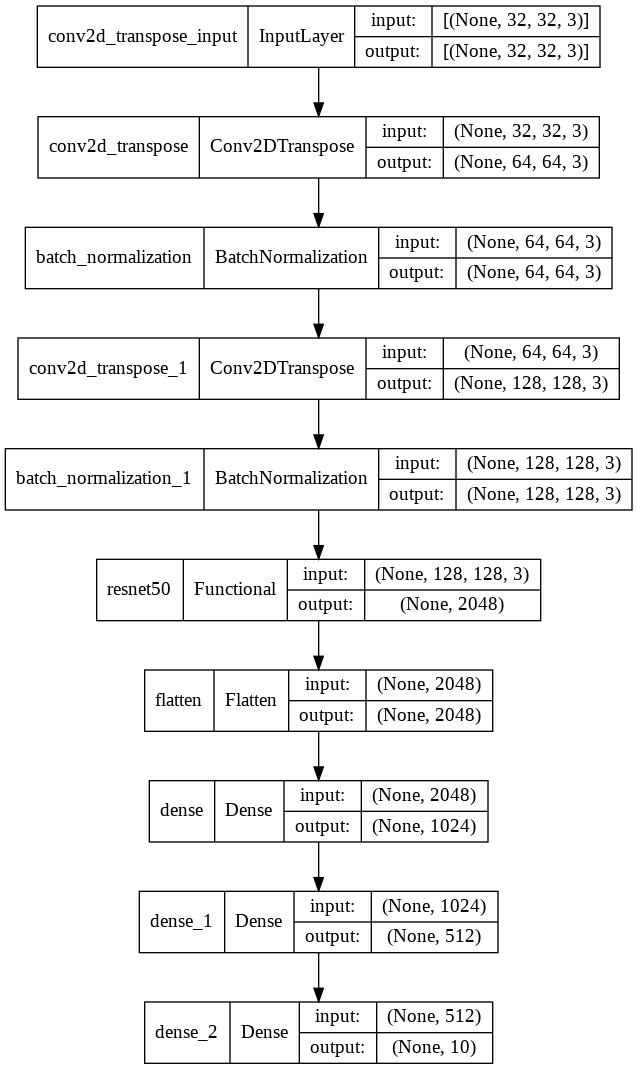

In [ ]:
model = model()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

def preprocess_image_input(input_images):
	input_images = input_images.astype('float32')
	output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
	return output_ims


In [ ]:
x_train, y_train, x_test, y_test = load_dataset()
models = []
# x_train, x_test = prep_pixels(x_train, x_test)
x_train = preprocess_image_input(x_train)
x_test = preprocess_image_input(x_test)
excluded_data_x = []
excluded_data_y = []
def run_test_harness():
  base_epochs = 1
  curr_model = 1 
  for i in range(0, x_train.shape[0], 5000):
      curr_x_train = x_train[i : (i+5000)]
      curr_y_train = y_train[i : (i+5000)]
      model_i = model()
      print("Training shard: " + str(curr_model) + " out of " + str((int)(x_train.shape[0] / 5000)))
      excluded_list = []
      excluded_list.append(random.randint(1,20))
      rand2 = random.randint(1,20)
      while rand2 == excluded_list[0]:
          rand2 = random.randint(1,20)
      excluded_list.append(rand2)

      for j in range(250, len(curr_x_train), 250):
          print("Training slice: " + str((int)(j/250)) + " out of " + str((int)(len(curr_x_train)/250)))
          if ((int)(j/250)) in excluded_list:
              excluded_data_x.append(curr_x_train[j-250 : j])
              excluded_data_y.append(curr_y_train[j-250 : j])
              print("Data excluded for "+ str((int)(j/250)))
              continue
          slice_x = curr_x_train[0: j]
          slice_y = curr_y_train[0: j]
          epochs = base_epochs * (int)(j/250)

          model_i.fit(slice_x, slice_y, batch_size=16, epochs=epochs, verbose=True)
      
      models.append(model_i)
      curr_model+=1

  return models


170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
# models = run_test_harness()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
models = np.load("/content/drive/MyDrive/models.npy", allow_pickle=True)

In [ ]:
# preds = []
# for i in range(models.shape[0]):
#   print(i+1)
#   for j in range(x_test.shape[0]):
#     preds.append(np.argmax(models[i].predict(x_test[j].reshape((-1,32,32,3)))))

preds = []
for i in range(models.shape[0]):
  print(str(i+1))
  pred = models[i].predict(x_test)
  pred = np.argmax(pred, axis=1)
  preds.append(pred)



1


KeyboardInterrupt: ignored

In [ ]:
preds = np.array(preds)

In [ ]:
final_preds = []
for i in range(preds[0].shape[0]):
  inter = []
  for j in range(10):
    inter.append(preds[j][i])
  ans = np.bincount(inter).argmax()
  final_preds.append(ans)


In [ ]:
final_preds = np.array(final_preds)

In [ ]:
(np.sum( np.argmax(y_test,axis=1) == final_preds) / final_preds.shape[0]) * 100

64.92999999999999

In [ ]:
np.argmax(y_test,axis=1).shape

(10000,)

In [ ]:
models

array([<keras.engine.sequential.Sequential object at 0x7f05069b5490>,
      dtype=object)

In [ ]:
# data_in_x = []
# data_in_y = []
# data_out_x = 
# data_out_y = 
predictions = []
true = []
var=0
for i in range(0, x_train.shape[0], 5000):
  curr_x_train = x_train[i:(i+5000)]
  curr_y_train = y_train[i:(i+5000)]
  # print(curr_x_train.shape)
  if i//5000==0:
    n1 = 3
    n2 = 10
  if i//5000==1:
    n1 = 4
    n2 = 6
  if i//5000==2:
    n1 = 6
    n2 = 7
  if i//5000==3:
    n1 = 9
    n2 = 10
  if i//5000==4:
    n1 = 11
    n2 = 12
  if i//5000==5:
    n1 = 13
    n2 = 18
  if i//5000==6:
    n1 = 8
    n2 = 9
  if i//5000==7:
    n1 = 4
    n2 =5
  if i//5000==8:
    n1 = 12
    n2 = 19
  if i//5000==9:
    n1 = 2
    n2 = 4
  for j in range(250, curr_x_train.shape[0], 250):
    x = j+1
    # x1 = 250 * (x-1)
    # x2 = 250 * (x)
    if((int)(j/250)== n1 or (int)(j/250)==n2):
      print("true")
    else:
      print(( (int)(i/5000) ))
      m = models[((int)(i/5000))]
      # print(x1)
      # print(x2)
      print(curr_x_train[x1:x2].shape)
      preds = m.predict(curr_x_train[j-250:j])
      dy = curr_y_train[j-250:j]
      for k in range(len(preds)):
        predictions.append(preds[k])
        true.append(dy[k])
      

  # if var:
  #   break
  



0
(250, 32, 32, 3)
0
(250, 32, 32, 3)
true
0
(250, 32, 32, 3)
0
(250, 32, 32, 3)
0
(250, 32, 32, 3)
0
(250, 32, 32, 3)
0
(250, 32, 32, 3)
0
(250, 32, 32, 3)
true
0
(250, 32, 32, 3)
0
(250, 32, 32, 3)
0
(250, 32, 32, 3)
0
(250, 32, 32, 3)
0
(250, 32, 32, 3)
0
(250, 32, 32, 3)
0
(250, 32, 32, 3)
0
(250, 32, 32, 3)
0
(250, 32, 32, 3)
1
(250, 32, 32, 3)
1
(250, 32, 32, 3)
1
(250, 32, 32, 3)
true
1
(250, 32, 32, 3)
true
1
(250, 32, 32, 3)
1
(250, 32, 32, 3)
1
(250, 32, 32, 3)
1
(250, 32, 32, 3)
1
(250, 32, 32, 3)
1
(250, 32, 32, 3)
1
(250, 32, 32, 3)
1
(250, 32, 32, 3)
1
(250, 32, 32, 3)
1
(250, 32, 32, 3)
1
(250, 32, 32, 3)
1
(250, 32, 32, 3)
1
(250, 32, 32, 3)
2
(250, 32, 32, 3)
2
(250, 32, 32, 3)
2
(250, 32, 32, 3)
2
(250, 32, 32, 3)
2
(250, 32, 32, 3)
true
true
2
(250, 32, 32, 3)
2
(250, 32, 32, 3)
2
(250, 32, 32, 3)
2
(250, 32, 32, 3)
2
(250, 32, 32, 3)
2
(250, 32, 32, 3)
2
(250, 32, 32, 3)
2
(250, 32, 32, 3)
2
(250, 32, 32, 3)
2
(250, 32, 32, 3)
2
(250, 32, 32, 3)
2
(250, 32, 32, 3)
3

In [ ]:
predictions = np.array(predictions)
true = np.array(true)

In [ ]:
predictions.shape

(42500, 10)

In [ ]:
true.shape

(42500, 10)

In [ ]:
predictions = np.argmax(predictions, axis=1)
true = np.argmax(true, axis=1)

In [ ]:
np.sum(predictions == true)/true.shape[0]

0.9997882352941176

In [ ]:

predictions1 = []
true1 = []
var=0
for i in range(0, x_train.shape[0], 5000):
  curr_x_train = x_train[i:(i+5000)]
  curr_y_train = y_train[i:(i+5000)]
  # print(curr_x_train.shape)
  if i//5000==0:
    n1 = 3
    n2 = 10
  if i//5000==1:
    n1 = 4
    n2 = 6
  if i//5000==2:
    n1 = 6
    n2 = 7
  if i//5000==3:
    n1 = 9
    n2 = 10
  if i//5000==4:
    n1 = 11
    n2 = 12
  if i//5000==5:
    n1 = 13
    n2 = 18
  if i//5000==6:
    n1 = 8
    n2 = 9
  if i//5000==7:
    n1 = 4
    n2 =5
  if i//5000==8:
    n1 = 12
    n2 = 19
  if i//5000==9:
    n1 = 2
    n2 = 4
  for j in range(250, curr_x_train.shape[0], 250):
    x = j+1
    # x1 = 250 * (x-1)
    # x2 = 250 * (x)
    if not ((int)(j/250)== n1 or (int)(j/250)==n2):
      print("true")
    else:
      print(( (int)(i/5000) ))
      m = models[((int)(i/5000))]
      # print(x1)
      # print(x2)
      print(curr_x_train[x1:x2].shape)
      preds = m.predict(curr_x_train[j-250:j])
      dy = curr_y_train[j-250:j]
      for k in range(len(preds)):
        predictions1.append(preds[k])
        true1.append(dy[k])
      

  # if var:
  #   break
  



true
true
0
(250, 32, 32, 3)
true
true
true
true
true
true
0
(250, 32, 32, 3)
true
true
true
true
true
true
true
true
true
true
true
true
1
(250, 32, 32, 3)
true
1
(250, 32, 32, 3)
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
2
(250, 32, 32, 3)
2
(250, 32, 32, 3)
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
3
(250, 32, 32, 3)
3
(250, 32, 32, 3)
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
4
(250, 32, 32, 3)
4
(250, 32, 32, 3)
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
5
(250, 32, 32, 3)
true
true
true
true
5
(250, 32, 32, 3)
true
true
true
true
true
true
true
true
6
(250, 32, 32, 3)
6
(250, 32, 32, 3)
true
true
true
true
true
true
true
true
true
true
true
true
true
7
(250, 32, 32, 3)
7
(250, 32, 32, 3)
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
t

In [ ]:
predictions1 = np.array(predictions1)
true1 = np.array(true1)

In [ ]:
predictions1 = np.argmax(predictions1, axis=1)
true1 = np.argmax(true1, axis=1)

In [ ]:
np.sum(predictions1 == true1)/true1.shape[0]

0.9756